In [69]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import csv 

In [71]:
data = pd.read_csv('./datasets/naver_movie_all.csv')
data = data[['document', 'label']]
print(data.shape)
data.head()

KeyError: "['document'] not in index"

In [3]:
train_data, test_data = train_test_split(data, test_size=0.33, random_state=777)

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 12415
테스트용 리뷰 개수 : 6115


In [5]:
train_data[:5] # 상위 5개 출력

,document,label
Unnamed: 0,,
3234,스토리가 넘 빈약함 영삼미는 멋찜,0
1577,NaN,1
6914,아휴.주인공들 OO짓 하게끔 만든거보는데 암걸리는줄...중간에 꺼버렸네여. 이런 스...,0
108,그래서 결론이 뭐야..? 결론이 대체 뭔지 모르겠는 영화. 엔딩보면서 뭘 어쩌라는건...,0
2423,"처음 영화관에서볼때,집에서 볼때,재개봉으로 다시볼때,모두 엄청난 후유증과 여운을 남...",1


In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 6115


In [7]:
test_data[:5]

,document,label
Unnamed: 0,,
3896,노잼.. 유치진짜 너무 유치해!!재미없어요 돈 아까워..너무 화나요돈 아까워서ㅡㅡ진...,0
1386,내가 이런 노잼 대만영화 처음본다 보지마세여^^ 알바꺼졍ㅎㅎ 凸(｀0´)凸,0
3437,내내 긴장해서..보는 내내 몸이아팠네요..너무긴장해서 몰입하다보니 스토리는 신경이덜...,1
6829,NaN,0
5638,댄싱 관련 영화였나요?,1


### Preprocessing

In [8]:
# 데이터 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(7787, 2)

In [9]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 7788


In [11]:
# train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
# 긍정과 부정의 수를 확인한다 (label=0이면 부정, label=1이면 긍정으로 표시한다)

# train_data['label'].value_counts()
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   2384
1      1   5404


In [13]:
train_data['label'].value_counts()

1    5404
0    2384
Name: label, dtype: int64

In [14]:
# 결측치 확인하기 - 나중참고용
# print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(train_data.isnull().any()) # Null 값이 존재하는지 확인
# print(len(train_data))

False
document    False
label       False
dtype: bool


In [15]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 알파벳과 공백을 제외하고 모두 제거(나중에 영어텍스트만 남기고 싶을때 사용)
# train_data['document'] = train_data['document'].str.replace("[^a-zA-Z ]","")

In [16]:
# https://www.unicode.org/charts/PDF/U3130.pdf
# ㄱ ~ ㅎ: 3131 ~ 314E
# ㅏ ~ ㅣ: 314F ~ 3163
# https://www.unicode.org/charts/PDF/UAC00.pdf
# 가 ~ 힣

In [17]:
train_data[:5]

,document,label
Unnamed: 0,,
3234,스토리가 넘 빈약함 영삼미는 멋찜,0
6914,아휴주인공들 짓 하게끔 만든거보는데 암걸리는줄중간에 꺼버렸네여 이런 스토리 극혐,0
108,그래서 결론이 뭐야 결론이 대체 뭔지 모르겠는 영화 엔딩보면서 뭘 어쩌라는건지 하고...,0
2423,처음 영화관에서볼때집에서 볼때재개봉으로 다시볼때모두 엄청난 후유증과 여운을 남긴다평...,1
3842,욕들어먹어도 싸지만긴장감은 괜찮았터미네이터편이 자꾸 생각나는건 기분탓일까,1


In [18]:
# 영어로만 작성된 리뷰도 삭제 됨
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    0
label       0
dtype: int64


In [19]:
train_data.loc[train_data.document.isnull()][:5]

,document,label
Unnamed: 0,,


In [20]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

7787


In [21]:
### test 데이터 전처리(tain과 동일)

In [22]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 4659


/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

### Tokenization

In [23]:
# 불용어 제거, 한국어의 조사, 접속사 등 -> 지속적으로 검토하면서 추가해서 삭제
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
# 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt
okt = Okt()
okt.morphs('2000년이후 최고의 서스펜스... 라고 했지만, 이걸 왜 봤을까', stem = True)

['2000년', '이후', '최고', '의', '서스펜스', '...', '라고', '하다', ',', '이', '걸', '왜', '보다']

In [25]:
# 불용어 제거
# 형태소 토큰화
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [39]:
print(X_train[0])

['스토리', '넘다', '빈약하다', '영', '삼', '밉다', '멋찜']


In [44]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
### 정수 인코딩

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [46]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '있다': 4, '없다': 5, '좋다': 6, '너무': 7, '이다': 8, '스토리': 9, '같다': 10, '다': 11, '연기': 12, '에서': 13, '되다': 14, '만': 15, '배우': 16, '재밌다': 17, '로': 18, '아니다': 19, '적': 20, '진짜': 21, '긴장감': 22, '것': 23, '않다': 24, '생각': 25, '평점': 26, '시간': 27, '만들다': 28, '안': 29, '나오다': 30, '그': 31, '점': 32, '사람': 33, '연출': 34, '나': 35, '게': 36, '인': 37, '내': 38, '못': 39, '정말': 40, '고': 41, '하고': 42, '왜': 43, '더': 44, '까지': 45, '감독': 46, '수': 47, '그냥': 48, '자다': 49, '보고': 50, '액션': 51, '들다': 52, '정도': 53, '때': 54, '가다': 55, '거': 56, '최고': 57, '말': 58, '싶다': 59, '이렇다': 60, '모르다': 61, '볼': 62, '오다': 63, '그렇다': 64, '하나': 65, '많다': 66, '주다': 67, '뭐': 68, '장면': 69, '느낌': 70, '저': 71, '요': 72, '알다': 73, '내용': 74, '아쉽다': 75, 'ㅋㅋ': 76, '재미있다': 77, '개': 78, '처음': 79, '중': 80, '넷플릭스': 81, '성': 82, '사냥': 83, '그리고': 84, '네': 85, '감동': 86, '이렇게': 87, '아깝다': 88, '작품': 89, '마지막': 90, '끝': 91, '많이': 92, '분': 93, '영': 94, '아': 95, '사랑': 96, '느끼다': 97, '한국': 98, '없이': 99, '걸': 100, '임': 101, '인데': 102, '

In [47]:
threshold = 3 # 빈도수가 3회 미만은 제거
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [48]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12140
등장 빈도가 2번 이하인 희귀 단어의 수: 7435
단어 집합에서 희귀 단어의 비율: 61.24382207578254
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.170357705767638


In [49]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4706


In [50]:
# 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환하는 정수 인코딩 과정에서 
# 이보다 큰 숫자가 부여된 단어들은 아예 계산하지 않음
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [51]:
print(X_train[:3])

[[9, 136, 1157, 94, 1554, 739], [95, 987, 103, 988, 160, 28, 2, 802, 476, 150, 160, 126, 85, 248, 60, 9, 3787], [435, 822, 68, 244, 822, 674, 319, 110, 61, 1, 447, 2, 328, 2046, 172, 279, 14]]


In [52]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플(Empty samples) 제거

In [53]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [54]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7733
7733


In [55]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

4626
4626


### 패딩

리뷰의 최대 길이 : 299
리뷰의 평균 길이 : 18.167981378507694


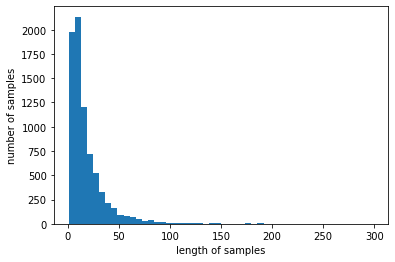

In [56]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [58]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [59]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 84.80537954222164


In [60]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM으로 네이버 영화 리뷰 감성 분류

In [61]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [62]:
T = X_train.shape[1]
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
i = Input(shape=(T,))
x = Embedding(vocab_size, 100)(i)
x = LSTM(128)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           470600    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 587,977
Trainable params: 587,977
Non-trainable params: 0
_________________________________________________________________


In [63]:
X_train.shape[1]

30

In [64]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     verbose=1, save_best_only=True)

In [ ]:
# OUTPUT_MODEL_DIR = "./model"
# OUTPUT_MODEL_FILE = "model.h5"

# import os
# model_file_path = os.path.join(OUTPUT_MODEL_DIR, OUTPUT_MODEL_FILE)
# model.save(model_file_path)

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, 
                    callbacks=[es, mc], batch_size=60, validation_split=0.2, verbose=2)

Train on 6186 samples, validate on 1547 samples
Epoch 1/15
6186/6186 [==============================] - 20s 3ms/sample - loss: 0.5227 - accuracy: 0.7459 - val_loss: 0.3847 - val_accuracy: 0.8332
Epoch 2/15
6186/6186 [==============================] - 13s 2ms/sample - loss: 0.3018 - accuracy: 0.8700 - val_loss: 0.3611 - val_accuracy: 0.8358
Epoch 3/15
6186/6186 [==============================] - 14s 2ms/sample - loss: 0.2142 - accuracy: 0.9145 - val_loss: 0.4029 - val_accuracy: 0.8300
Epoch 4/15
6186/6186 [==============================] - 14s 2ms/sample - loss: 0.1669 - accuracy: 0.9370 - val_loss: 0.4943 - val_accuracy: 0.8035
Epoch 5/15
6186/6186 [==============================] - 15s 2ms/sample - loss: 0.1261 - accuracy: 0.9534 - val_loss: 0.5474 - val_accuracy: 0.8171
Epoch 6/15
6186/6186 [==============================] - 14s 2ms/sample - loss: 0.0969 - accuracy: 0.9685 - val_loss: 0.6125 - val_accuracy: 0.8164
Epoch 00006: early stopping


In [66]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

4626/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================